In [1]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.4 MB/s 
     |████████████████████████████████| 4.0 MB 25.2 MB/s 
     |████████████████████████████████| 1.2 MB 76.4 MB/s 
     |████████████████████████████████| 77 kB 4.8 MB/s 
     |████████████████████████████████| 880 kB 68.5 MB/s 
     |████████████████████████████████| 6.6 MB 55.2 MB/s 
     |████████████████████████████████| 596 kB 47.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=4c51ff96eaa6312e66fd81ebf546cfa3760084368da0d254b0cd31b04a747ab8
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=1ee444b711829fe11b660b52c7e1fa4dd9e898050050d1b9614d57ed94609abe
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sentence-transformers sa

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [4]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
articles_df = pd.read_csv('data/articles_df_filt_with_counts_and_age.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(40538, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0110065001,"Microfibre T-shirt bra with underwired, moulde...",2
3,0110065002,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065011,"Microfibre T-shirt bra with underwired, moulde...",4


In [8]:
customers = pd.read_csv('data/customers_filt_with_counts_and_age.csv')
print(customers.shape)
customers.head()

(43108, 5)


,customer_id,FN,Active,age,customer_id_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,0.45,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,0.44,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,0.21,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0.0,0.0,0.21,4


In [9]:
PADDING_VALUE = articles_df['article_id_idx'].max() + 1
PADDING_VALUE

40538

In [10]:
MAX_LENGTH = 10

class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, total_articles, padding_value=PADDING_VALUE, max_length=MAX_LENGTH):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.padding_value = padding_value
        
        self.max_length = max_length
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str, num_purchases_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        num_purchases = torch.tensor([float(v) for v in num_purchases_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, num_purchases)
        
        target = target / target.sum()  # Normalise

        return target
    
    def padded_input_sequence(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])
        
        # Pad input
        if len(indices) < self.max_length:
        
            num_pad = self.max_length - len(indices)
            
            indices = F.pad(indices, (0, num_pad), value=self.padding_value)
            
        return indices
    
    def process_numeric_features(self, fn: str, active: str, age: str, example_age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age),
            float(example_age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age, num_purchases, example_age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age, example_age)
            
            input_seq = self.padded_input_sequence(article_id_idx_last10)

            label = self.process_label(article_id_idx_label, num_purchases)            

            yield customer_id_idx, input_seq, numeric_features_tensor, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

### Create article EmbeddingBag

In [11]:
model = SentenceTransformer('all-distilroberta-v1')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

In [12]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [13]:
model.encode(article_descriptions[0]).shape

(768,)

In [14]:
embeddings = model.encode(article_descriptions)

In [15]:
embeddings = torch.tensor(embeddings)

In [16]:
embeddings.shape

torch.Size([40538, 768])

In [17]:
padding_emb = torch.randn([1, 768])

In [18]:
embeddings = torch.concat([embeddings, padding_emb], dim=0)
embeddings.shape

torch.Size([40539, 768])

In [19]:
ARTICLE_EMBEDDING = nn.Embedding.from_pretrained(embeddings=embeddings, freeze=True)

In [28]:
ARTICLE_EMBEDDING = ARTICLE_EMBEDDING.to(device)

### Model

In [20]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)        
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        
        # LSTM
        self.lstm = torch.nn.LSTM(input_size=768, hidden_size=768, batch_first=True)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+768+4, out_features=2048)            
        self.fc_2 = nn.Linear(in_features=2048, out_features=1024)
        # self.fc_3 = nn.Linear(in_features=1024, out_features=512)
        self.fc_3 = nn.Linear(in_features=1024, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.01)
        
    def forward(
        self, 
        customer_id_idx, 
        input_seq, 
        numeric_features_tensor
    ):

        user_emb = self.user_embeddings(customer_id_idx)
        
        article_emb = ARTICLE_EMBEDDING(input_seq)
        
        inputs = self.lstm(article_emb)   
        
        all_h_t, _ = self.lstm(article_emb)
        h_T = all_h_t[:, -1, :]  # Final cell outputs
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                h_T,
                numeric_features_tensor
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc_4(x)

        return x

In [21]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [22]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(43108, 384)
  (lstm): LSTM(768, 768, batch_first=True)
  (fc_1): Linear(in_features=1156, out_features=2048, bias=True)
  (fc_2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=40538, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

In [23]:
BATCH_SIZE = 1024

In [24]:
total_training_examples = pd.read_csv('data/final_train_set_with_counts_and_age.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

43.0

In [25]:
total_dev_examples = pd.read_csv('data/final_dev_set_with_counts_and_age.tsv', sep='\t').shape[0]
total_dev_batches = np.ceil(total_dev_examples/BATCH_SIZE)
total_dev_batches

9.0

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.0001)  # 0.001

In [106]:
MAX_EPOCHS = 25  # 150

# training_losses = []
# dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age.tsv', total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, inputs, numeric_features_tensor, label = data
        customer_id_idx, inputs, numeric_features_tensor, label = customer_id_idx.to(device), inputs.to(device), numeric_features_tensor.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs, numeric_features_tensor)
        
        loss = criterion(y_pred, label)

        loss.backward()    
        
        optimizer.step()
        
    # Compute train loss:
    
    total_train_loss = 0

    fashion_rec_v3.eval()
    
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age.tsv', total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(train_loader, total=total_batches):

            customer_id_idx, inputs, numeric_features_tensor, label = data
            customer_id_idx, inputs, numeric_features_tensor, label = customer_id_idx.to(device), inputs.to(device), numeric_features_tensor.to(device), label.to(device)

            y_pred = fashion_rec_v3(customer_id_idx, inputs, numeric_features_tensor)

            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / total_training_examples
        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
        
    # Compute dev loss:
    
    total_dev_loss = 0
    
    dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set_with_counts_and_age.tsv', total_articles=len(articles_df))    
    
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(dev_loader, total=total_dev_batches):

            customer_id_idx, inputs, numeric_features_tensor, label = data
            customer_id_idx, inputs, numeric_features_tensor, label = customer_id_idx.to(device), inputs.to(device), numeric_features_tensor.to(device), label.to(device)

            y_pred = fashion_rec_v3(customer_id_idx, inputs, numeric_features_tensor)
            
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_dev_loss += loss.item()

        mean_dev_loss = total_train_loss / total_dev_examples
        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
        
    fashion_rec_v3.train()

100%|██████████| 43/43.0 [00:09<00:00,  4.67it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.20it/s]


Training loss: 0.856086392565031


100%|██████████| 9/9.0 [00:02<00:00,  4.34it/s]


Dev loss: 4.04651011082164


100%|██████████| 43/43.0 [00:09<00:00,  4.70it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.19it/s]


Training loss: 0.8557197365146229


100%|██████████| 9/9.0 [00:02<00:00,  4.27it/s]


Dev loss: 4.044777017727233


100%|██████████| 43/43.0 [00:09<00:00,  4.67it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.24it/s]


Training loss: 0.8556445550861059


100%|██████████| 9/9.0 [00:02<00:00,  4.22it/s]


Dev loss: 4.0444216535802475


100%|██████████| 43/43.0 [00:09<00:00,  4.65it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.22it/s]


Training loss: 0.8552873464023136


100%|██████████| 9/9.0 [00:02<00:00,  4.39it/s]


Dev loss: 4.042733215867427


100%|██████████| 43/43.0 [00:09<00:00,  4.64it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.19it/s]


Training loss: 0.8553640667003084


100%|██████████| 9/9.0 [00:02<00:00,  4.29it/s]


Dev loss: 4.043095853872466


100%|██████████| 43/43.0 [00:09<00:00,  4.62it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.19it/s]


Training loss: 0.8549680147917005


100%|██████████| 9/9.0 [00:02<00:00,  4.30it/s]


Dev loss: 4.0412238137763845


100%|██████████| 43/43.0 [00:09<00:00,  4.61it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.20it/s]


Training loss: 0.8548417680281439


100%|██████████| 9/9.0 [00:02<00:00,  4.33it/s]


Dev loss: 4.040627076333029


100%|██████████| 43/43.0 [00:09<00:00,  4.58it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.15it/s]


Training loss: 0.8547526143019082


100%|██████████| 9/9.0 [00:02<00:00,  4.28it/s]


Dev loss: 4.04020566856652


100%|██████████| 43/43.0 [00:09<00:00,  4.57it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.15it/s]


Training loss: 0.8545122940376383


100%|██████████| 9/9.0 [00:02<00:00,  4.26it/s]


Dev loss: 4.039069733703346


100%|██████████| 43/43.0 [00:09<00:00,  4.58it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.17it/s]


Training loss: 0.854253139745396


100%|██████████| 9/9.0 [00:02<00:00,  4.31it/s]


Dev loss: 4.037844775015848


100%|██████████| 43/43.0 [00:09<00:00,  4.56it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.18it/s]


Training loss: 0.8541743331686888


100%|██████████| 9/9.0 [00:02<00:00,  4.33it/s]


Dev loss: 4.037472275683754


100%|██████████| 43/43.0 [00:09<00:00,  4.55it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.12it/s]


Training loss: 0.8538118896739231


100%|██████████| 9/9.0 [00:02<00:00,  4.17it/s]


Dev loss: 4.035759094305206


100%|██████████| 43/43.0 [00:09<00:00,  4.55it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.21it/s]


Training loss: 0.8538689246544471


100%|██████████| 9/9.0 [00:02<00:00,  4.17it/s]


Dev loss: 4.036028684649551


100%|██████████| 43/43.0 [00:09<00:00,  4.55it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.17it/s]


Training loss: 0.8535699209875351


100%|██████████| 9/9.0 [00:02<00:00,  4.31it/s]


Dev loss: 4.034615367755555


100%|██████████| 43/43.0 [00:09<00:00,  4.54it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.18it/s]


Training loss: 0.8535141894887482


100%|██████████| 9/9.0 [00:02<00:00,  4.32it/s]


Dev loss: 4.034351938649228


100%|██████████| 43/43.0 [00:09<00:00,  4.55it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.17it/s]


Training loss: 0.8532658917038674


100%|██████████| 9/9.0 [00:02<00:00,  4.31it/s]


Dev loss: 4.0331782960055165


100%|██████████| 43/43.0 [00:09<00:00,  4.53it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.19it/s]


Training loss: 0.8529716839294349


100%|██████████| 9/9.0 [00:02<00:00,  4.33it/s]


Dev loss: 4.031787648117333


100%|██████████| 43/43.0 [00:09<00:00,  4.51it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.22it/s]


Training loss: 0.8529875430457278


100%|██████████| 9/9.0 [00:02<00:00,  4.24it/s]


Dev loss: 4.031862610264828


100%|██████████| 43/43.0 [00:09<00:00,  4.53it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.16it/s]


Training loss: 0.8529090757459372


100%|██████████| 9/9.0 [00:02<00:00,  4.25it/s]


Dev loss: 4.031491714611388


100%|██████████| 43/43.0 [00:09<00:00,  4.52it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.17it/s]


Training loss: 0.8526429638876326


100%|██████████| 9/9.0 [00:02<00:00,  4.19it/s]


Dev loss: 4.03023386921799


100%|██████████| 43/43.0 [00:09<00:00,  4.53it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.20it/s]


Training loss: 0.8526725418616107


100%|██████████| 9/9.0 [00:02<00:00,  4.29it/s]


Dev loss: 4.030373677036218


100%|██████████| 43/43.0 [00:09<00:00,  4.54it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.19it/s]


Training loss: 0.8525742839393075


100%|██████████| 9/9.0 [00:02<00:00,  4.29it/s]


Dev loss: 4.029909235971016


100%|██████████| 43/43.0 [00:09<00:00,  4.54it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.21it/s]


Training loss: 0.8524163155804829


100%|██████████| 9/9.0 [00:02<00:00,  4.20it/s]


Dev loss: 4.029162558338099


100%|██████████| 43/43.0 [00:09<00:00,  4.54it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.20it/s]


Training loss: 0.8522240041502886


100%|██████████| 9/9.0 [00:02<00:00,  4.25it/s]


Dev loss: 4.028253549441956


100%|██████████| 43/43.0 [00:09<00:00,  4.52it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.21it/s]


Training loss: 0.8520422122513218


100%|██████████| 9/9.0 [00:02<00:00,  4.27it/s]

Dev loss: 4.027394263786182


150 epochs, LR 0.001

13 epochs, LR 0.0003 (training loss becomes very bouncy)

25 epochs, LR 0.0001 (beats previous best loss very quickly but MAP@12 worse)

Remaining, LR 0.0001

In [107]:
training_losses[-1], dev_losses[-1]

(0.8520422122513218, 4.027394263786182)

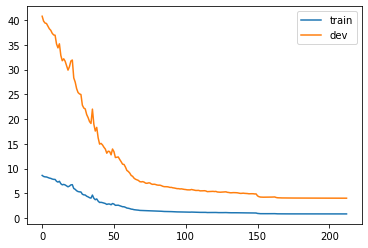

In [108]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### MAP@12

#### Train

In [109]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_with_counts_and_age.tsv', total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():

    for data in tqdm(dev_loader, total=total_batches):

        customer_id_idx, inputs, numeric_features_tensor, label = data
        customer_id_idx, inputs, numeric_features_tensor, label = customer_id_idx.to(device), inputs.to(device), numeric_features_tensor.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs, numeric_features_tensor)

        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 43/43.0 [00:07<00:00,  5.82it/s]


In [110]:
predictions = torch.concat(predictions)

In [111]:
predictions.shape

torch.Size([43108, 1000])

In [112]:
actuals = pd.read_csv('data/final_train_set_with_counts_and_age.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

43108

In [113]:
mapk(actuals, predictions.tolist(), 12)

0.997148624230684

🤯

In [114]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [115]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

0.99999359197454

In [116]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [117]:
np.mean(np.array(number_of_positive_examples ) > 0)

1.0

Model is a strong top-1000 candidate generator:
- 99+% precision
- Can use all customers in training set since each has at least 1 positive example 

This could then facilitate a 2-stage approach like YouTube

#### Dev

In [118]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set_with_counts_and_age.tsv', total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():

    for data in tqdm(dev_loader, total=total_dev_batches):

        customer_id_idx, inputs, numeric_features_tensor, label = data
        customer_id_idx, inputs, numeric_features_tensor, label = customer_id_idx.to(device), inputs.to(device), numeric_features_tensor.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs, numeric_features_tensor)

        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 9/9.0 [00:01<00:00,  5.80it/s]


In [119]:
predictions = torch.concat(predictions)

In [120]:
predictions.shape

torch.Size([9120, 1000])

In [121]:
actuals = pd.read_csv('data/final_dev_set_with_counts_and_age.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

9120

In [122]:
mapk(actuals, predictions.tolist(), 12)

0.05329242185288462

In [123]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [124]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

0.3260373831038937

In [125]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [126]:
np.mean(np.array(number_of_positive_examples) > 0)

0.5460526315789473

In a 2-step approach this is the metric we would care about most. 35% is similar to what was achieved with simple heuristic candidate generators but here we also acheive strong MAP!

In [127]:
actuals_perfect_order = [[i for i in act if i in pred] for act, pred in zip(actuals, predictions.tolist())]

In [128]:
mapk(actuals_perfect_order, predictions.tolist(), 12)

0.0727303463986477

#### Test

In [129]:
total_test_batches = np.ceil(pd.read_csv('data/final_test_set_with_counts_and_age.tsv', sep='\t').shape[0]/BATCH_SIZE)

In [130]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_test_set_with_counts_and_age.tsv', total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():

    for data in tqdm(dev_loader, total=total_test_batches):

        customer_id_idx, inputs, numeric_features_tensor, label = data
        customer_id_idx, inputs, numeric_features_tensor, label = customer_id_idx.to(device), inputs.to(device), numeric_features_tensor.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs, numeric_features_tensor)

        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 9/9.0 [00:01<00:00,  5.96it/s]


In [131]:
predictions = torch.concat(predictions)

In [132]:
predictions.shape

torch.Size([8733, 1000])

In [133]:
actuals = pd.read_csv('data/final_test_set_with_counts_and_age.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

8733

In [137]:
mapk(actuals, predictions.tolist(), 12)

0.01716785114343227

In [135]:
# Number of unique items in predictions
len(predictions.unique())

17601

In [136]:
# Number of unique items in actuals
len(set([item for sublist in actuals for item in sublist]))

8318

LSTM doesn't do much better than mean embedding bag. Lowering learning rate mid-training looks promising though.